# Nighttime Lights and GDP Analysis

## Library

In [1]:
from pathlib import Path

import plotnine as p9
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import pandas as pd
import numpy as np
import geopandas as gpd

import warnings

warnings.filterwarnings("ignore")

## Functions

In [2]:
def clean_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names."""
    df = df.rename(columns=lambda col: col.strip().lower().replace(" ", "_"))
    return df


def find_project_root(marker_file: str = "pyproject.toml"):
    for parent in Path().cwd().parents:
        if (parent / marker_file).exists():
            return parent
    raise FileNotFoundError(f"No project root found with marker file: {marker_file}")


In [3]:
PROJECT_ROOT = find_project_root()
DATA_PATH = PROJECT_ROOT / "data"
BOUNDARIES_PATH = DATA_PATH / "Shapefiles"

## Data

This analysis utilizes the following datasets:

* Overall GDP Data: Sourced from the World Bank World Development Indicators (WDI) database
* Sectoral GDP Data: Provided by the Myanmar team
* Nighttime Lights Data: Obtained from the NOAA's VIIRS Collection 2 products

In [4]:
adm1 = gpd.read_file(
    BOUNDARIES_PATH / "mmr_polbnda2_adm1_250k_mimu" / "mmr_polbnda2_adm1_250k_mimu.shp"
)

adm4 = gpd.read_file(BOUNDARIES_PATH / "adm4.geojson")

sez_locations_raw = pd.read_csv(DATA_PATH / "NTL" / "sez_locations.csv").pipe(
    lambda df: gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.lon, df.lat, crs="EPSG:4326")
    )
)

sez_adm1_count = (
    adm1.sjoin(sez_locations_raw, predicate="contains", how="inner")
    .groupby("ST")
    .agg(sez_count=("Name", "size"))
    .reset_index()
    .pipe(clean_names)
    .rename(columns={"st": "adm1_name"})
)

In [5]:
gdp_overall = (
    (
        pd.read_csv(DATA_PATH / "GDP" / "GDP All Countries.csv", skiprows=4)
        .pipe(clean_names)
        .loc[lambda df: df["country_name"] == "Myanmar"]
    )
    .melt(
        id_vars=["country_name", "country_code", "indicator_name", "indicator_code"],
        var_name="year",
        value_name="gdp_overall",
    )
    .dropna(subset=["gdp_overall"])
    .assign(
        date=lambda df: pd.to_datetime(df["year"], format="%Y"),
        gdp_overall=lambda df: df["gdp_overall"] / 1_000_000,
    )
    .set_index("date")
)

In [6]:
gdp_quarterly_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx",
    sheet_name=1,
    skiprows=1,
    skipfooter=1,
)
gdp_adm1_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx", sheet_name=0, skiprows=1
).rename(columns={"Unnamed: 0": "ADM1_NAME"})

In [7]:
ntl_annual_adm0 = (
    pd.read_csv(DATA_PATH / "NTL" / "ntl_annual_adm0_collection2.csv")
    .drop(columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"])
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .sort_index()
)

ntl_annual_adm1 = (
    pd.read_csv(DATA_PATH / "NTL" / "ntl_annual_adm1_collection2.csv")
    .drop(columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"])
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .sort_index()
)

ntl_monthly_adm0_raw = pd.read_csv(
    DATA_PATH / "NTL" / "ntl_monthly_adm0_collection2.csv"
).drop(columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"])
ntl_monthly_adm1_raw = pd.read_csv(
    DATA_PATH / "NTL" / "ntl_monthly_adm1_collection2.csv"
).drop(columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"])
ntl_monthly_adm4_raw = pd.read_parquet(
    DATA_PATH / "NTL" / "ntl_monthly_adm4_collection2.parquet"
)


ntl_quarterly_adm0 = (
    ntl_monthly_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="QS"))
    .agg({"ntl_sum": "sum"})
    .assign(
        ntl_sum_lag_1=lambda df: df["ntl_sum"].shift(1),
        ntl_sum_lag_2=lambda df: df["ntl_sum"].shift(2),
        ntl_sum_lag_3=lambda df: df["ntl_sum"].shift(3),
    )
)

ntl_quarterly_adm1 = (
    ntl_monthly_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"ntl_sum": "sum"})
    .reset_index()
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            ntl_sum_lag_1=df["ntl_sum"].shift(1),
            ntl_sum_lag_2=df["ntl_sum"].shift(2),
            ntl_sum_lag_3=df["ntl_sum"].shift(3),
        )
    )
    .reset_index(drop=True)
    .set_index(["adm1_name", "date"])
)

In [8]:
gdp_adm1_name_map = {
    "Ayeyarwaddy Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magwe Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw Council": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Tanintharyi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


def preprocess_bago_and_shan(df: pd.DataFrame) -> pd.DataFrame:
    """Split the values of Bago into two equal parts and Shan into three equal parts."""
    df_bago = df.query("adm1_name == 'Bago'").copy()
    df_bago_new = pd.DataFrame(
        {
            "adm1_name": ["Bago (East)", "Bago (West)"],
            "agriculture": [df_bago["agriculture"].values[0] / 2] * 2,
            "industry": [df_bago["industry"].values[0] / 2] * 2,
            "services": [df_bago["services"].values[0] / 2] * 2,
        }
    )

    df_shan = df.query("adm1_name == 'Shan'").copy()
    df_shan_new = pd.DataFrame(
        {
            "adm1_name": ["Shan (South)", "Shan (East)", "Shan (North)"],
            "agriculture": [df_shan["agriculture"].values[0] / 3] * 3,
            "industry": [df_shan["industry"].values[0] / 3] * 3,
            "services": [df_shan["services"].values[0] / 3] * 3,
        }
    )

    df_rest = df.query("adm1_name not in ['Bago', 'Shan']").copy()

    return pd.concat([df_rest, df_bago_new, df_shan_new], ignore_index=True)


gdp_adm1 = (
    gdp_adm1_raw.pipe(clean_names)
    .assign(adm1_name=lambda df: df["adm1_name"].map(gdp_adm1_name_map))
    .pipe(preprocess_bago_and_shan)
    .assign(industry_pct=lambda df: df["industry"] / df["industry"].sum())
)

gdp_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        quarter_clean=lambda df: df["quarter"].str.strip(),
        year_first=lambda df: df["year"].str.split("-").str[0].str.strip(),
        year_last=lambda df: df["year"].str.split("-").str[1].str.strip(),
        # Map fiscal quarters to calendar quarters and years
        calendar_quarter=lambda df: df["quarter_clean"].map(
            {"Q1": "Q2", "Q2": "Q3", "Q3": "Q4", "Q4": "Q1"}
        ),
        year_selected=lambda df: df.apply(
            lambda row: row["year_last"]
            if row["quarter_clean"] == "Q4"
            else row["year_first"],
            axis=1,
        ),
        date=lambda df: pd.to_datetime(df["year_selected"] + df["calendar_quarter"]),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .query('sub_group == "Industry" and economic_activity == "Manufacturing"')
    .set_index("date")
    .sort_index()
    .groupby(["sub_group", "economic_activity", pd.Grouper(freq="QS")])
    .agg({"gdp": "sum"})
    .reset_index()
    .sort_values(["sub_group", "date"])
    .assign(
        gdp_lag_1=lambda df: df["gdp"].shift(1),
        gdp_lag_2=lambda df: df["gdp"].shift(2),
    )
)

gdp_quarterly_adm1 = (
    pd.DataFrame(
        [
            (region, period)
            for region in gdp_adm1["adm1_name"].unique()
            for period in gdp_quarterly["date"].unique()
        ],
        columns=["adm1_name", "date"],
    )
    .merge(gdp_adm1.filter(["adm1_name", "industry_pct"]), on="adm1_name", how="left")
    .merge(gdp_quarterly, on="date", how="left")
    .rename(
        columns={
            "gdp": "gdp_total",
            "gdp_lag_1": "gdp_lag_1_total",
            "gdp_lag_2": "gdp_lag_2_total",
        }
    )
    .assign(
        gdp=lambda df: df["gdp_total"] * df["industry_pct"],
        gdp_lag_1=lambda df: df["gdp_lag_1_total"] * df["industry_pct"],
        gdp_lag_2=lambda df: df["gdp_lag_2_total"] * df["industry_pct"],
    )
    .set_index(["adm1_name", "date"])
    .filter(["gdp", "gdp_lag_1", "gdp_lag_2"])
)

In [9]:
ntl_monthly_adm4 = ntl_monthly_adm4_raw.merge(
    adm4.filter(["ADM4_PCODE", "ADM3_PCODE", "geometry"]),
    on=["ADM4_PCODE", "ADM3_PCODE"],
    how="left",
).pipe(gpd.GeoDataFrame)

In [10]:
(
    ntl_monthly_adm4.sjoin(
        sez_locations_raw,
        predicate="contains",
        how="left",
    )
    .assign(sez_present=lambda df: np.where(df["index_right"].notna(), 1, 0))
    .groupby("sez_present")
    .agg(
        mean_ntl_sum=("ntl_sum", "mean"),
        count=("ntl_sum", "size"),
        p80_ntl_sum=("ntl_sum", lambda x: np.nanpercentile(x, 80)),
        p90_ntl_sum=("ntl_sum", lambda x: np.nanpercentile(x, 90)),
        p95_ntl_sum=("ntl_sum", lambda x: np.nanpercentile(x, 95)),
    )
)

,mean_ntl_sum,count,p80_ntl_sum,p90_ntl_sum,p95_ntl_sum
sez_present,,,,,
0,15.088117,2369304,8.753453,24.748451,53.618059
1,598.971252,16296,1170.352047,1814.885468,2320.622323


## Analysis

### Overall GDP vs Nighttime Lights

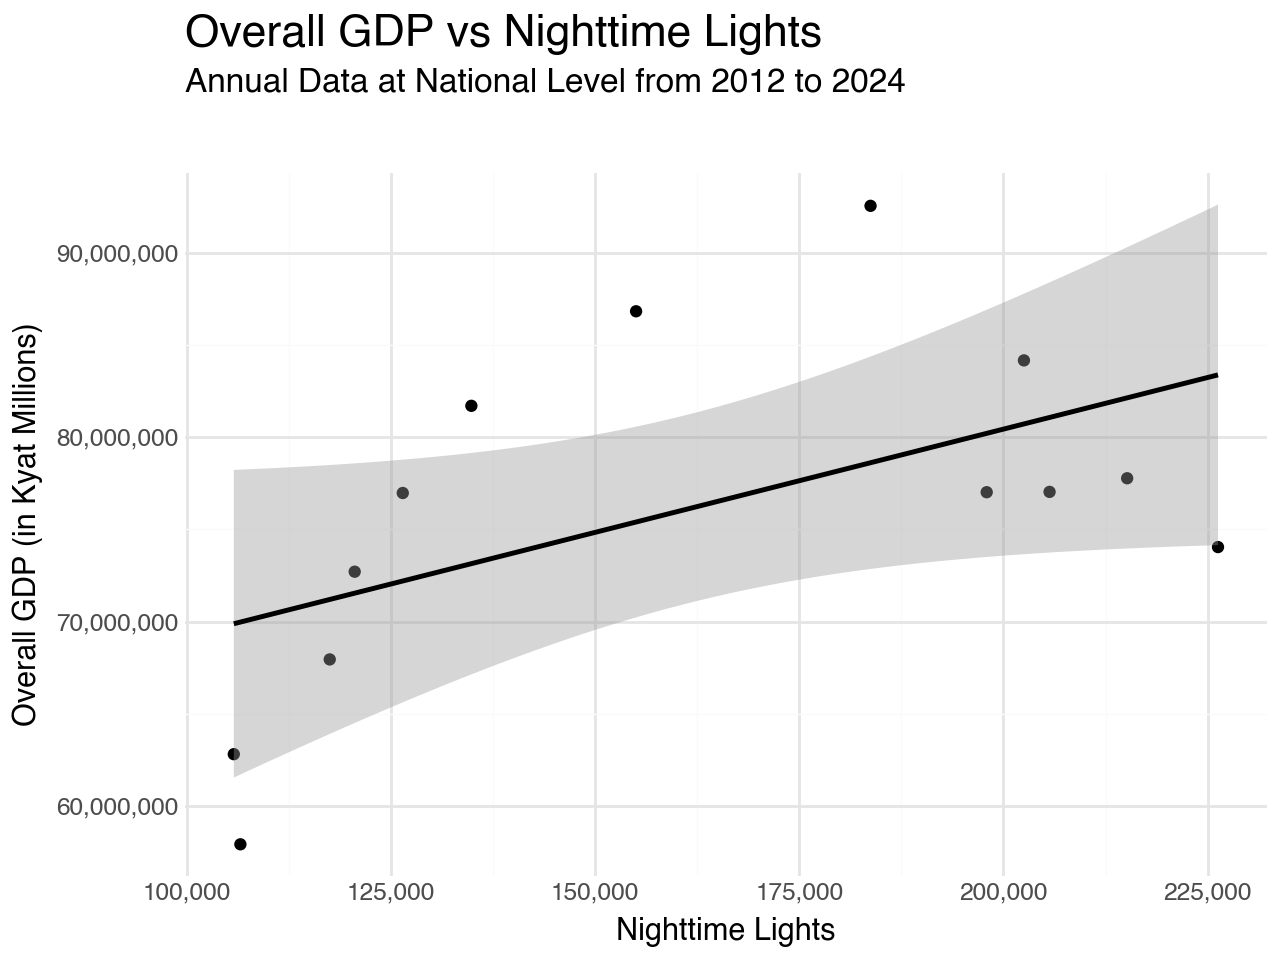

In [11]:
# Overall GDP vs Nighttime Lights
(
    gdp_overall.join(ntl_annual_adm0, how="inner").pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_overall")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_x_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="Overall GDP vs Nighttime Lights",
        subtitle="Annual Data at National Level from 2012 to 2024",
        x="Nighttime Lights",
        y="Overall GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_title=p9.element_text(size=16, weight="bold"),
        plot_subtitle=p9.element_text(size=12, margin={"b": 20}),
    )
)


In [12]:
gdp_overall_ntl = gdp_overall.join(ntl_annual_adm0, how="inner").assign(
    gdp_overall_log=lambda df: np.log(df["gdp_overall"]),
    ntl_sum_log=lambda df: np.log(df["ntl_sum"]),
)

mod = smf.ols("gdp_overall_log ~ ntl_sum_log", data=gdp_overall_ntl).fit()

Stargazer([mod])

### Manufacturing GDP vs Nighttime Lights

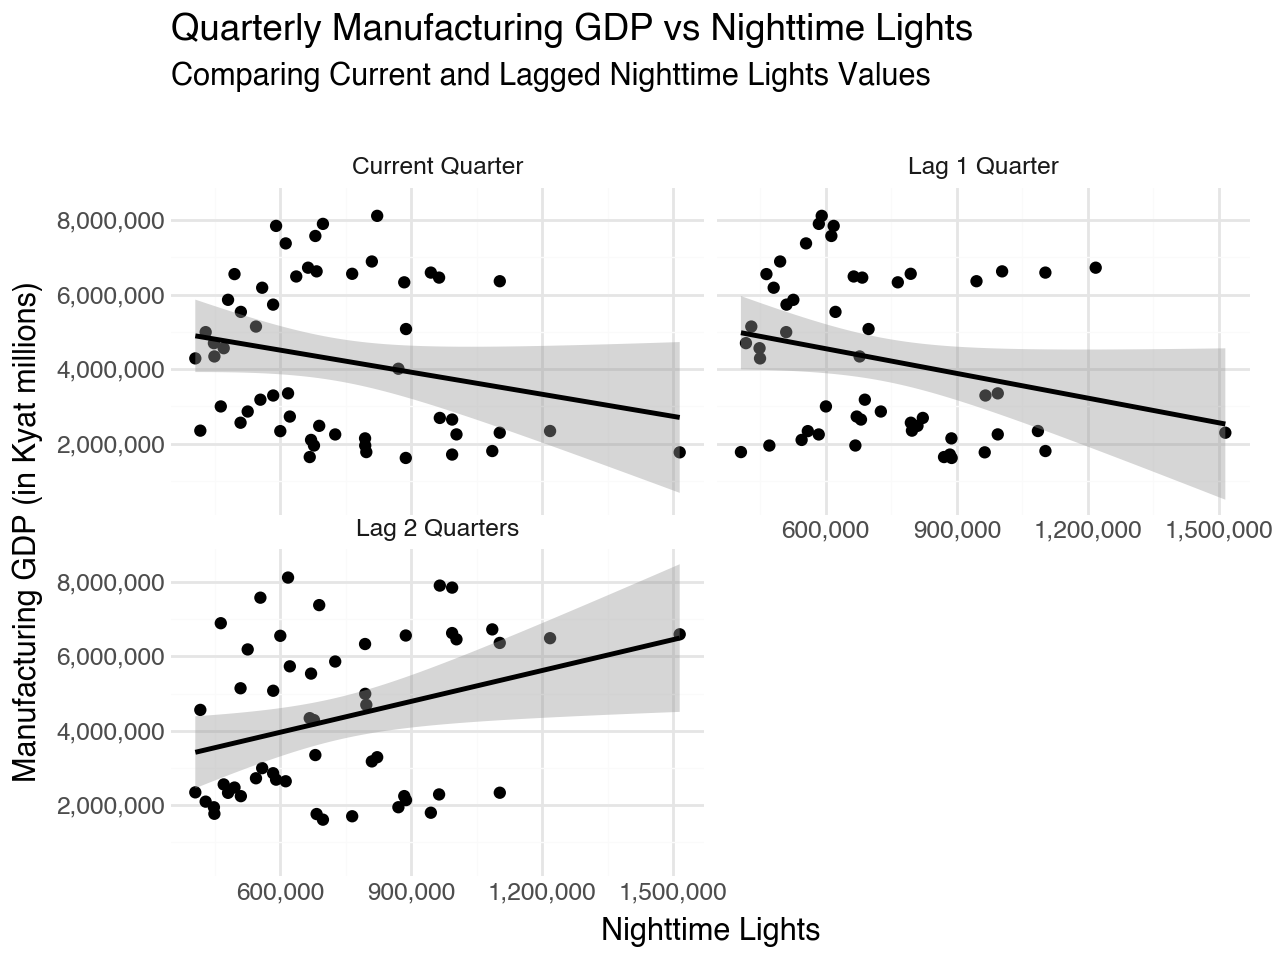

In [21]:
(
    gdp_quarterly.set_index("date")
    .join(ntl_quarterly_adm0, how="inner")
    .reset_index()
    .melt(
        id_vars=["date", "gdp"],
        value_vars=["ntl_sum", "ntl_sum_lag_1", "ntl_sum_lag_2"],
    )
    .assign(
        variable=lambda df: df["variable"].map(
            {
                "ntl_sum": "Current Quarter",
                "ntl_sum_lag_1": "Lag 1 Quarter",
                "ntl_sum_lag_2": "Lag 2 Quarters",
            }
        )
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("~variable", ncol=2)
    + p9.scale_x_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="Quarterly Manufacturing GDP vs Nighttime Lights",
        subtitle="Comparing Current and Lagged Nighttime Lights Values",
        x="Nighttime Lights",
        y="Manufacturing GDP (in Kyat millions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_subtitle=p9.element_text(margin={"b": 20}),
    )
)

In [14]:
gdp_quarterly_adm0 = (
    gdp_quarterly.set_index("date")
    .join(ntl_quarterly_adm0, how="inner")
    .assign(
        ntl_sum_lag_1=lambda df: df["ntl_sum"].shift(1),
        ntl_sum_lag_2=lambda df: df["ntl_sum"].shift(2),
        gdp_log=lambda df: np.log(df["gdp"]),
        ntl_sum_log=lambda df: np.log(df["ntl_sum"]),
        ntl_sum_lag_1_log=lambda df: np.log(df["ntl_sum_lag_1"]),
        ntl_sum_lag_2_log=lambda df: np.log(df["ntl_sum_lag_2"]),
    )
)

mod_1 = smf.ols("gdp_log ~ ntl_sum_log", data=gdp_quarterly_adm0).fit()
mod_2 = smf.ols("gdp_log ~ ntl_sum_lag_1_log", data=gdp_quarterly_adm0).fit()
mod_3 = smf.ols("gdp_log ~ ntl_sum_lag_2_log", data=gdp_quarterly_adm0).fit()

models = Stargazer([mod_1, mod_2, mod_3])
models.custom_columns(
    [
        "Current",
        "Lag 1 Quarter",
        "Lag 2 Quarters",
    ],
    [1, 1, 1],
)
models.covariate_order(
    [
        "ntl_sum_log",
        "ntl_sum_lag_1_log",
        "ntl_sum_lag_2_log",
    ]
)
models

### Admin Level 1

In [15]:
(
    gdp_adm1.filter(["adm1_name", "industry_pct"])
    .assign(
        industry_pct=lambda df: df["industry_pct"].apply(
            lambda x: "{:.1f}%".format(x * 100)
        )
    )
    .rename(columns={"industry_pct": "Industry"})
)

,adm1_name,Industry
0,Ayeyarwady,5.1%
1,Chin,0.3%
2,Kachin,1.9%
3,Kayah,0.2%
4,Kayin,1.3%
5,Magway,7.9%
6,Mandalay,12.3%
7,Mon,4.1%
8,Nay Pyi Taw,1.7%
9,Rakhine,2.6%


### Manufacturing GDP vs Nighttime Lights across Admin Level 1 Regions

In [16]:
ntl_indicators_adm1 = (
    gdp_quarterly_adm1.join(ntl_quarterly_adm1, how="inner")
    .reset_index()
    .merge(sez_adm1_count, on="adm1_name", how="left")
    .sort_values(["adm1_name", "date"])
    .assign(
        gdp_log=lambda df: np.log(df["gdp"]),
        ntl_sum_log=lambda df: np.log(df["ntl_sum"]),
        ntl_sum_lag_1_log=lambda df: np.log(df["ntl_sum_lag_1"]),
        ntl_sum_lag_2_log=lambda df: np.log(df["ntl_sum_lag_2"]),
        ntl_sum_lag_3_log=lambda df: np.log(df["ntl_sum_lag_3"]),
        sez_count=lambda df: df["sez_count"].fillna(0),
        sez_count_log=lambda df: np.log1p(df["sez_count"]),
        has_sez=lambda df: np.where(df["sez_count"] > 0, 1, 0),
    )
    .drop(columns=["gdp_lag_1", "gdp_lag_2"])
)

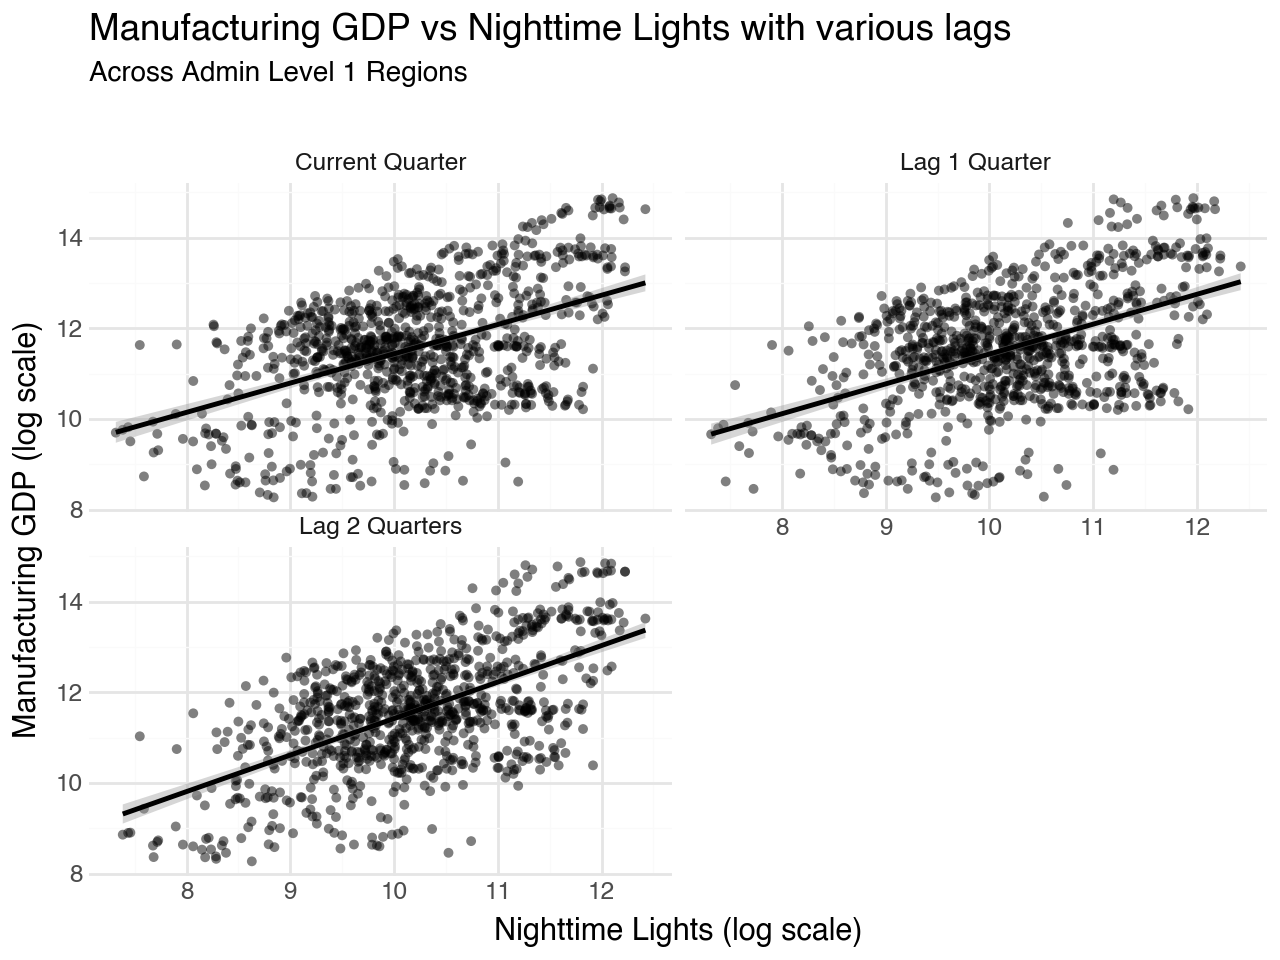

In [17]:
(
    ntl_indicators_adm1.filter(
        ["date", "gdp_log", "ntl_sum_log", "ntl_sum_lag_1_log", "ntl_sum_lag_2_log"]
    )
    .melt(id_vars=["gdp_log", "date"])
    .dropna(subset=["value"])
    .assign(
        variable=lambda df: df["variable"].replace(
            {
                "ntl_sum_log": "Current Quarter",
                "ntl_sum_lag_1_log": "Lag 1 Quarter",
                "ntl_sum_lag_2_log": "Lag 2 Quarters",
            }
        )
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="Manufacturing GDP vs Nighttime Lights with various lags",
        subtitle="Across Admin Level 1 Regions",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(plot_subtitle=p9.element_text(margin={"b": 20}, size=10))
)

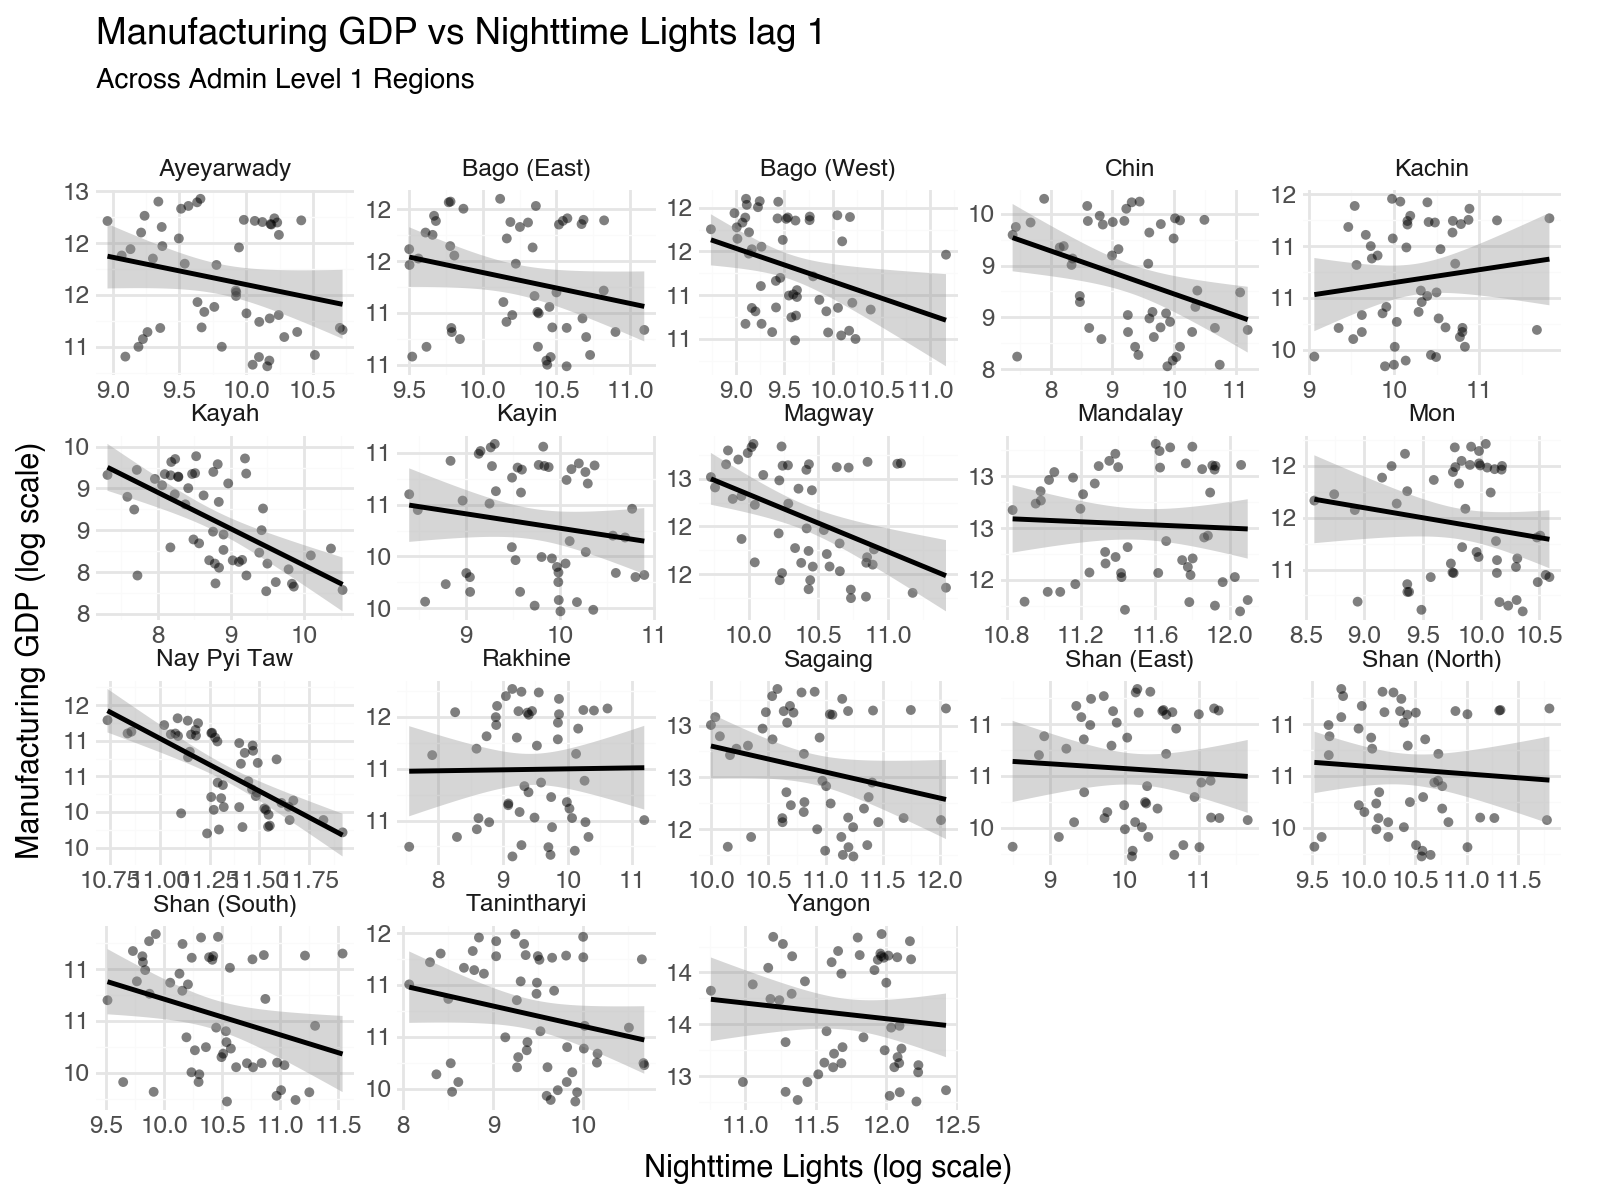

In [18]:
(
    ntl_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_lag_1_log", y="gdp_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("adm1_name", scales="free")
    + p9.labs(
        title="Manufacturing GDP vs Nighttime Lights lag 1",
        subtitle="Across Admin Level 1 Regions",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(
        figure_size=(8, 6), plot_subtitle=p9.element_text(margin={"b": 20}, size=10)
    )
)

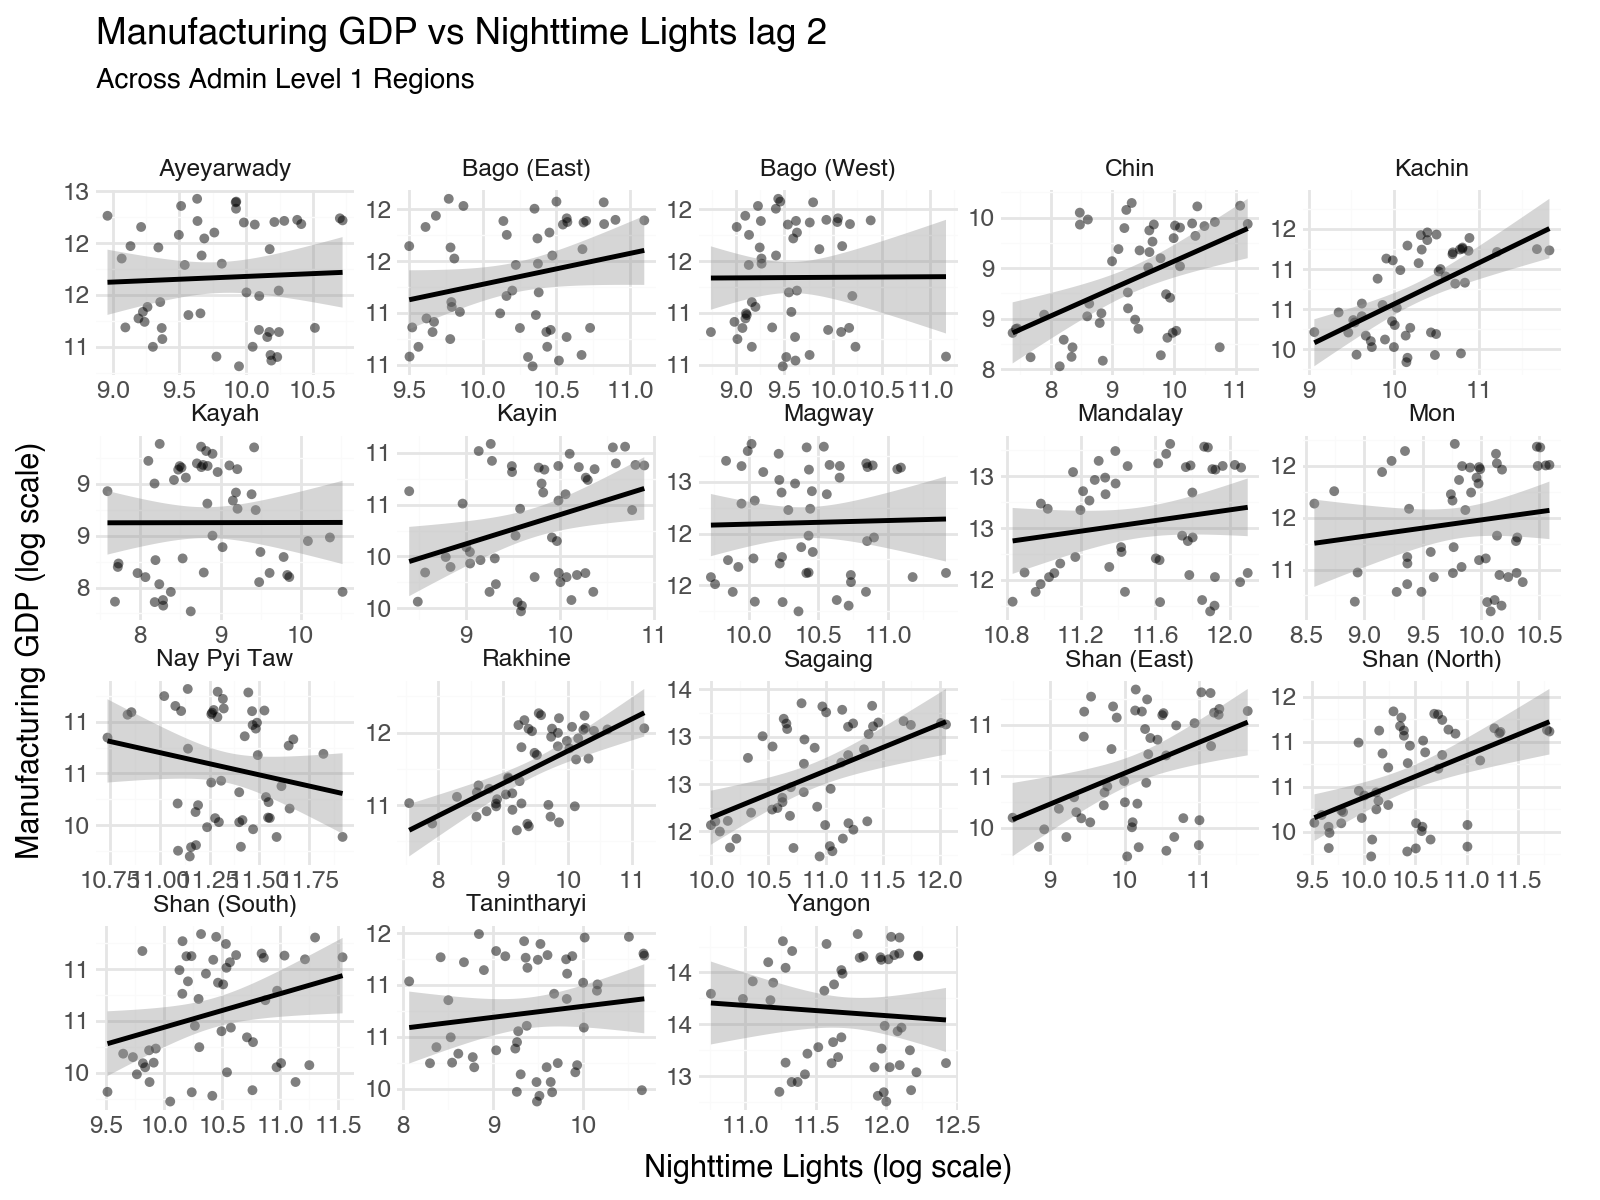

In [19]:
(
    ntl_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_lag_2_log", y="gdp_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("adm1_name", scales="free")
    + p9.labs(
        title="Manufacturing GDP vs Nighttime Lights lag 2",
        subtitle="Across Admin Level 1 Regions",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(
        figure_size=(8, 6), plot_subtitle=p9.element_text(margin={"b": 20}, size=10)
    )
)

### Regression Analysis

In [20]:
mod_1 = smf.ols("gdp_log ~ ntl_sum_log + sez_count_log", data=ntl_indicators_adm1).fit()
mod_2 = smf.ols(
    "gdp_log ~ ntl_sum_lag_1_log + sez_count_log", data=ntl_indicators_adm1
).fit()
mod_3 = smf.ols(
    "gdp_log ~ ntl_sum_lag_2_log + sez_count_log",
    data=ntl_indicators_adm1,
).fit()
mod_4 = smf.ols(
    "gdp_log ~ ntl_sum_log + sez_count_log + C(adm1_name)",
    data=ntl_indicators_adm1,
).fit()
mod_5 = smf.ols(
    "gdp_log ~ ntl_sum_lag_2_log + sez_count_log + C(adm1_name)",
    data=ntl_indicators_adm1,
).fit()
mod_6 = smf.mixedlm(
    "gdp_log ~ ntl_sum_log + sez_count_log",
    data=ntl_indicators_adm1.dropna(),
    groups=ntl_indicators_adm1.dropna()["adm1_name"],
    re_formula="~ntl_sum_log",
).fit()

mod_7 = smf.mixedlm(
    "gdp_log ~ ntl_sum_lag_2_log + sez_count_log",
    data=ntl_indicators_adm1.dropna(),
    groups=ntl_indicators_adm1.dropna()["adm1_name"],
    re_formula="~ntl_sum_lag_2_log",
).fit()


models = Stargazer([mod_1, mod_2, mod_3, mod_4, mod_5, mod_6, mod_7])
models.custom_columns(
    [
        "Current only",
        "1 Quarter Lag",
        "2 Quarter Lag",
        "Current + Region FE",
        "2 Quarter Lag + Region FE",
        "Current + Mixed Effects",
        "2 Quarter Lag + Mixed Effects",
    ],
    [1, 1, 1, 1, 1, 1, 1],
)
models.covariate_order(
    [
        "Intercept",
        "ntl_sum_log",
        "ntl_sum_lag_1_log",
        "ntl_sum_lag_2_log",
        "sez_count_log",
    ]
)
models